In [ ]:
#Autor: Andrés
#Tarea: https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/20#issue-2913499571
#Objetivo: crear un arbol de decision que sepa predecir el ganador de una pelea 
#          en la base de datos que no contiene las estadisticas ponderadas

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

En esta sección, cargamos los datos desde un archivo local para asegurar que todos los integrantes del grupo utilicen la misma partición de datos, garantizando consistencia en el análisis y los resultados.

In [52]:
ruta_train = os.path.join("..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_val = os.path.join("..","..", "data", "P1","validation.parquet")
val = pd.read_parquet(ruta_val) 
val = val.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

En esta sección, dividimos los datos en tres conjuntos: entrenamiento (train), validación (validation) y prueba (test). Además, separamos la variable objetivo (lo que queremos predecir) del resto de las variables predictoras (características que usamos para hacer la predicción). Esto nos permite entrenar el modelo, ajustar los hiperparámetros y evaluar su desempeño de manera independiente en datos no vistos.

In [53]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_val = val.drop(columns=["WINNER"])
y_val = val["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

En esta sección, entrenamos un árbol de decisión básico sin realizar ningún ajuste de hiperparámetros. El objetivo es observar el comportamiento inicial del modelo, obteniendo una primera aproximación de su rendimiento antes de realizar mejoras o ajustes. Esto nos proporciona una referencia para comparar los resultados posteriores con un modelo más afinado.

F1-score en validación: 0.7995

Clasificación (Validación):
              precision    recall  f1-score   support

       False       0.89      0.88      0.89       753
        True       0.79      0.81      0.80       424

    accuracy                           0.85      1177
   macro avg       0.84      0.84      0.84      1177
weighted avg       0.85      0.85      0.85      1177

F1-score en test: 0.7842

Clasificación (Test):
              precision    recall  f1-score   support

       False       0.88      0.88      0.88       746
        True       0.78      0.78      0.78       431

    accuracy                           0.84      1177
   macro avg       0.83      0.83      0.83      1177
weighted avg       0.84      0.84      0.84      1177



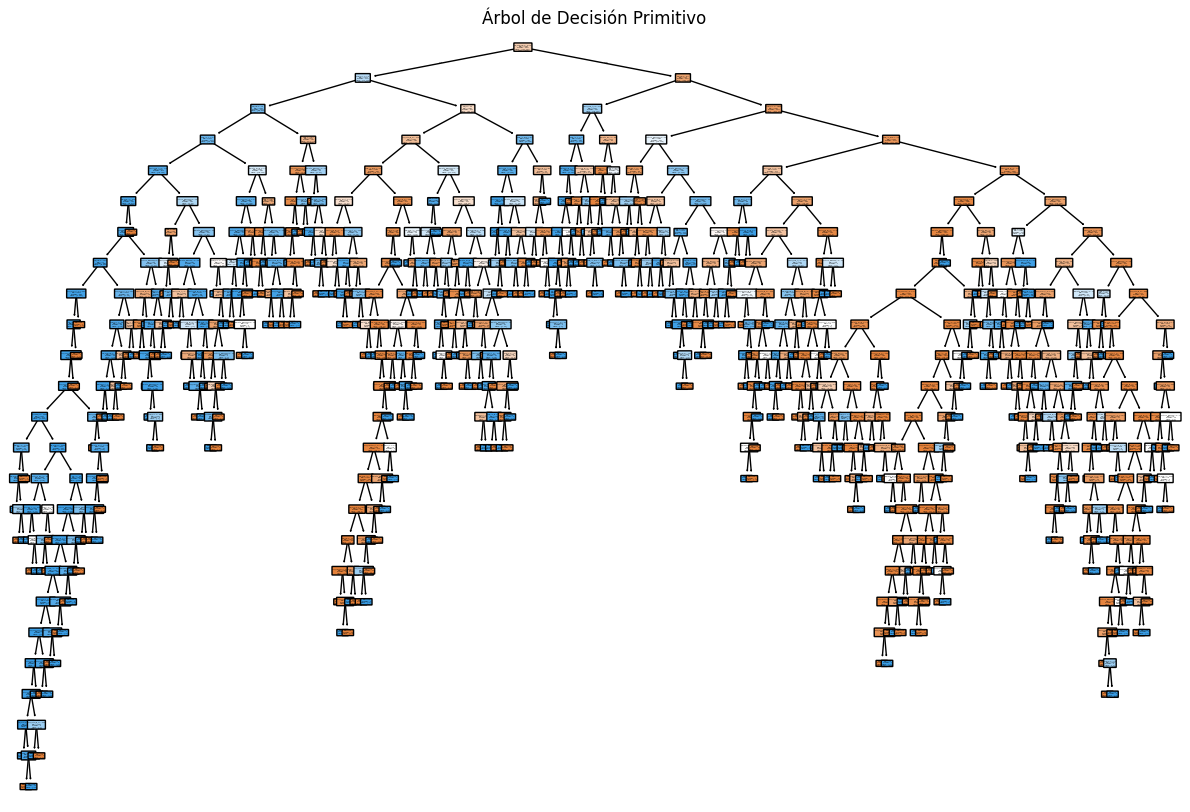

In [70]:
###### ARBOL DE DECISION PRIMITIVO SIN AJUSTE DE HIPERPARAMETROS #####

# Crear el modelo base
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluar en validación
y_val_pred = clf.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)
print(f'F1-score en validación: {f1_val:.4f}')

print("\nClasificación (Validación):")
print(classification_report(y_val, y_val_pred))

# Evaluar en test
y_test_pred = clf.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

# Mostrar el reporte de clasificación para test
print("\nClasificación (Test):")
print(classification_report(y_test, y_test_pred))

# Visualizar el árbol de decisión (opcional)
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["B gana", "A gana"], rounded=True)
plt.title("Árbol de Decisión Primitivo")
plt.show()


Podemos observar que los resultados obtenidos con este primer modelo sin ajustes de hiperparámetros no son tan malos. La precisión es bastante buena en comparación con los resultados que veremos más adelante, lo que sugiere que el árbol de decisión, incluso sin optimización, ya es capaz de hacer predicciones razonablemente acertadas. Esto nos da una base para medir la mejora cuando realicemos ajustes más detallados en el modelo.

En esta sección, se utiliza Grid Search para encontrar los mejores hiperparámetros para el modelo de árbol de decisión. Este proceso evalúa múltiples combinaciones de parámetros y selecciona los que maximizan el rendimiento del modelo. Tras realizar el ajuste, se construye un nuevo modelo utilizando los mejores parámetros encontrados, lo que debería mejorar la precisión y la capacidad predictiva en comparación con el modelo inicial.

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1-score en validación: 0.8062
F1-score en test: 0.7938

Reporte de clasificación (Validación):
              precision    recall  f1-score   support

       False       0.89      0.90      0.89       753
        True       0.82      0.79      0.81       424

    accuracy                           0.86      1177
   macro avg       0.85      0.85      0.85      1177
weighted avg       0.86      0.86      0.86      1177


Reporte de clasificación (Test):
              precision    recall  f1-score   support

       False       0.87      0.90      0.89       746
        True       0.82      0.77      0.79       431

    accuracy                           0.85      1177
   macro avg       0.84      0.84      0.84      1177
weighted avg       0.85      0.85      0.85      1177



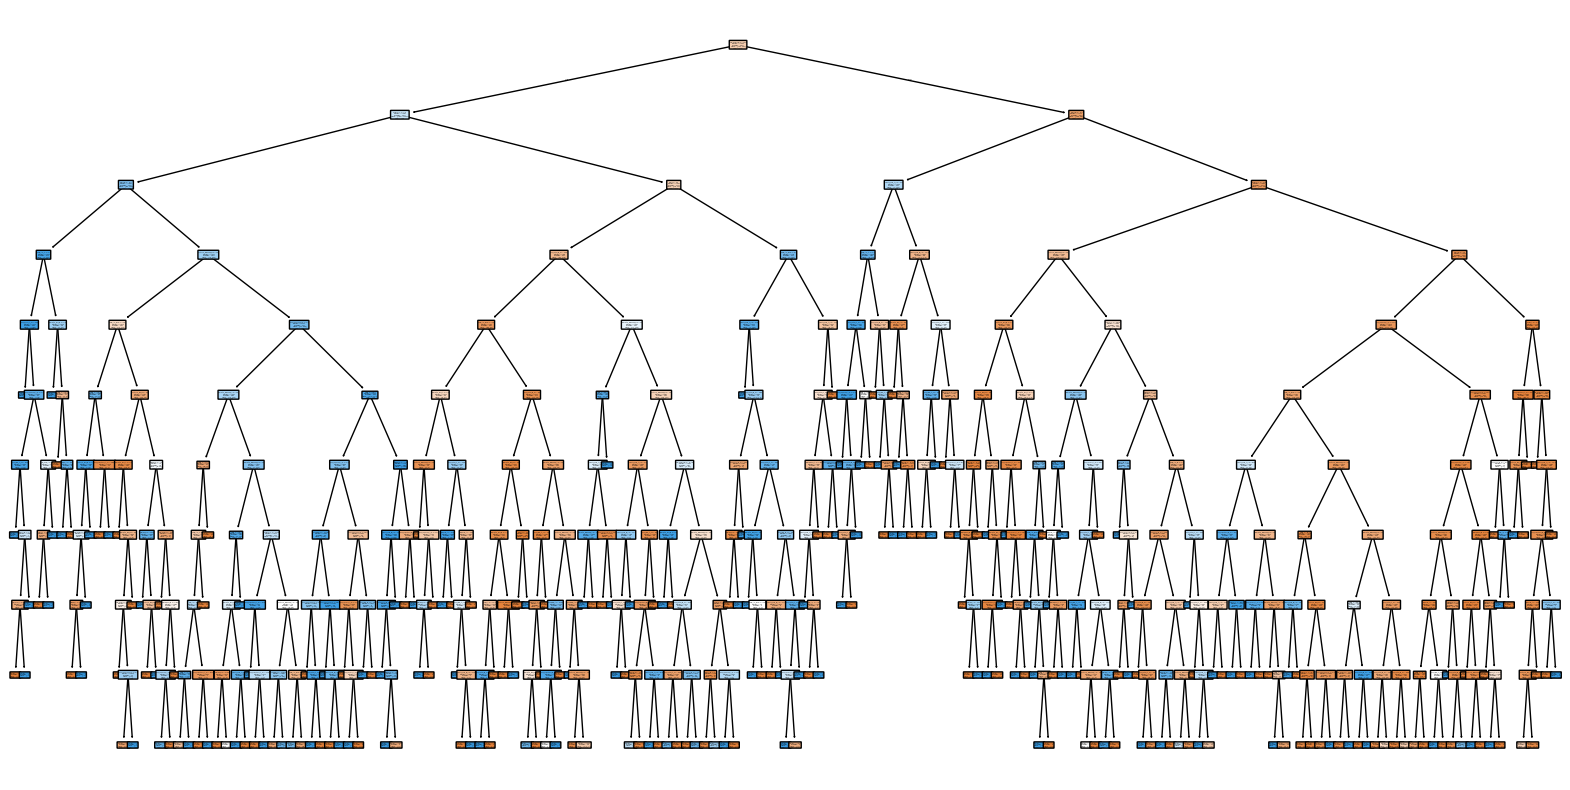

In [73]:
# Definir los hiperparámetros que queremos probar
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Crear el modelo base
clf = DecisionTreeClassifier(random_state=42)

# Crear el GridSearchCV con validación cruzada de 5 folds usando F1-score
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Obtener el mejor modelo entrenado con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Evaluar en el conjunto de validación con F1-score
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred)
print(f'F1-score en validación: {f1_val:.4f}')

# Evaluar en el conjunto de prueba con F1-score
y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

# Mostrar reporte de clasificación
print("\nReporte de clasificación (Validación):")
print(classification_report(y_val, y_val_pred))

print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_test_pred))

# Mostrar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X_train.columns, class_names=["False", "True"], filled=True, rounded=True)
plt.show()


Después de realizar la selección de los mejores parámetros mediante Grid Search, al evaluar el modelo optimizado, observamos que los resultados son ligeramente mejores en comparación con el modelo inicial. Sin embargo, existen otros modelos que alcanzan una mayor precisión. Esto nos lleva a la conclusión de que, aunque los árboles de decisión son muy útiles para identificar variables significativas, no suelen ser los mejores modelos finales en términos de precisión predictiva.

En esta sección, se realiza un estudio de la importancia de las variables utilizando el modelo de árbol de decisión seleccionado. El objetivo es identificar cuáles de las características o variables tienen un mayor impacto en la predicción del modelo. Este análisis nos ayuda a comprender mejor el comportamiento del modelo y a determinar qué factores son los más relevantes para predecir el resultado.

C:\Users\araca\AppData\Local\Temp\ipykernel_19496\2554305338.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')


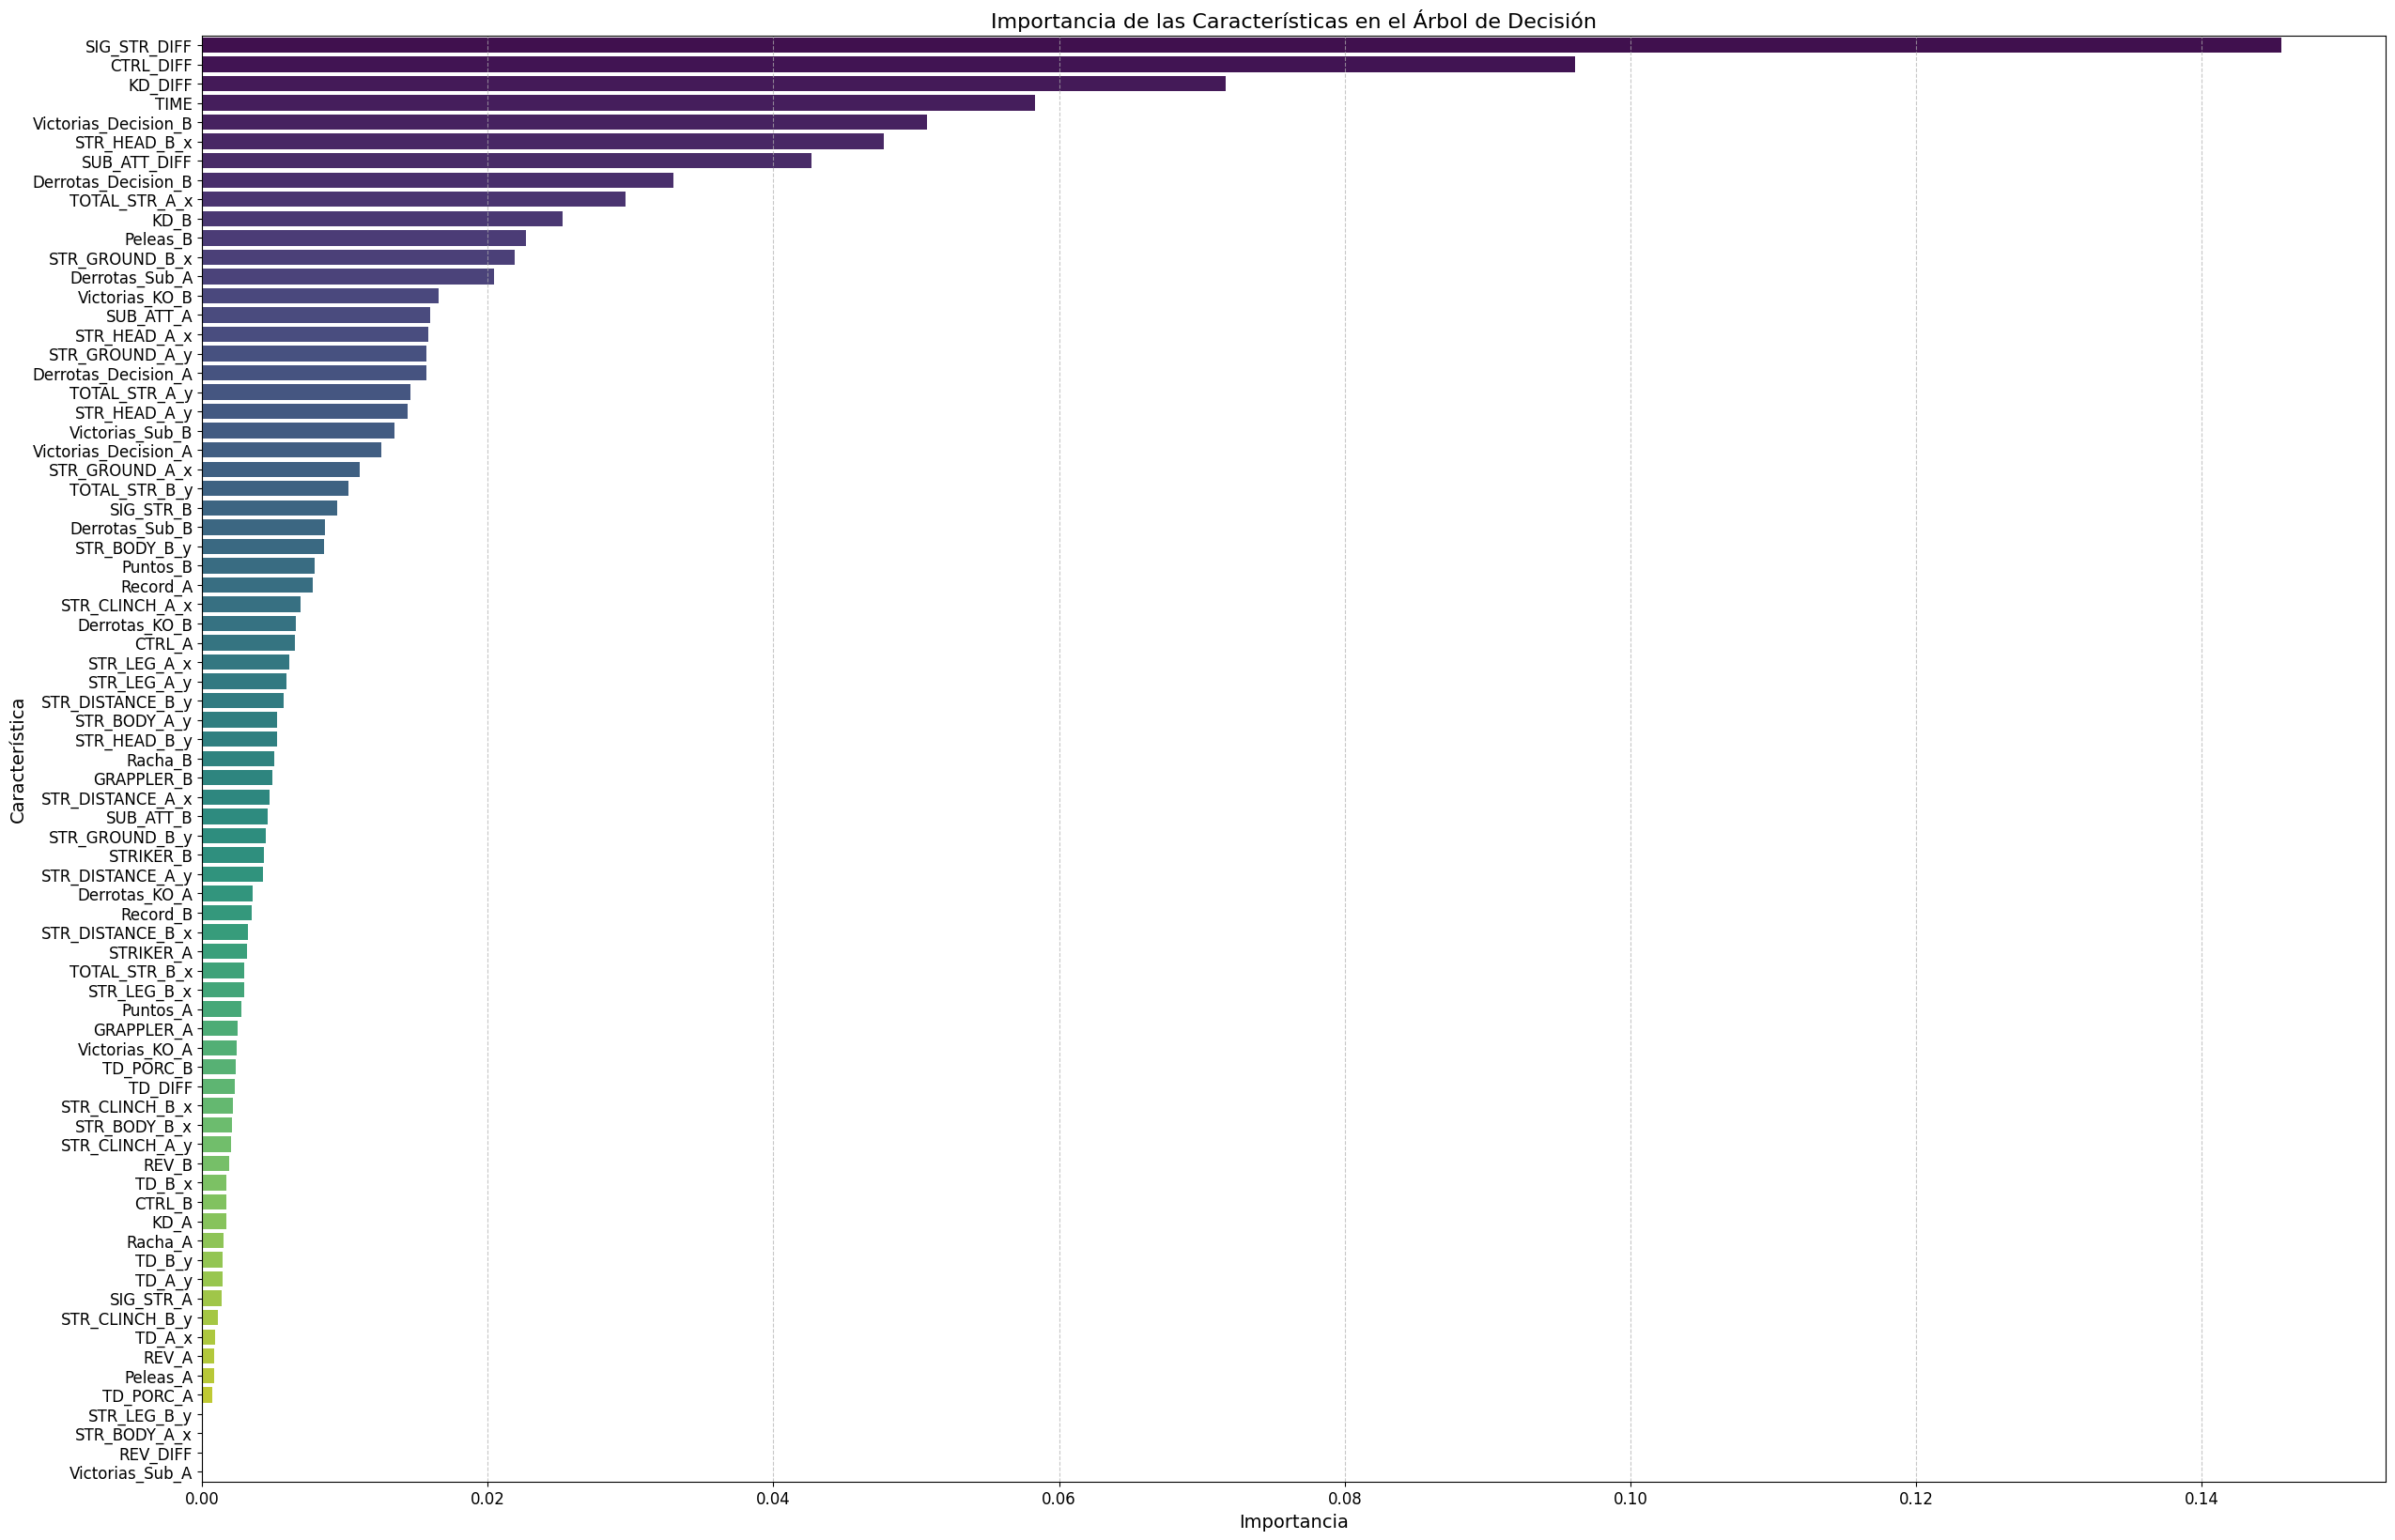

In [66]:
# Obtener la importancia de las características
feature_importance = best_model.feature_importances_

# Crear un DataFrame
feature_importance_df = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance})

# Ordenar de mayor a menor importancia
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Graficar
plt.figure(figsize=(30, 20))  # Aumentamos el tamaño de la figura
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')

# Ajustes de diseño
plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Característica', fontsize=14)
plt.title('Importancia de las Características en el Árbol de Decisión', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Agregar una rejilla sutil en el eje X

# Mostrar el gráfico
plt.show()


En el gráfico de importancia de variables, podemos observar que algunas variables tienen un peso considerable, mientras que otras ni siquiera son tenidas en cuenta por el modelo. Este análisis resulta útil a la hora de realizar transformaciones para otros modelos, ya que podemos optar por descartar las variables menos relevantes y centrarnos en las que tienen más peso en el árbol. De esta manera, optimizamos el modelo al reducir la complejidad y enfocarnos en los factores clave para las predicciones.

En esta sección, se realiza un análisis de las predicciones generadas por el modelo en comparación con los resultados reales. El objetivo es evaluar el rendimiento del modelo y entender en qué casos acierta o se equivoca. Este análisis nos permite identificar patrones, posibles sesgos o áreas de mejora en el modelo, lo que puede ser útil para futuros ajustes y optimización.

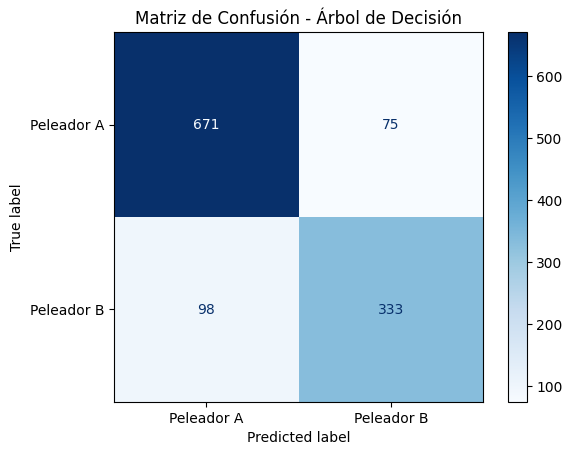

In [67]:
# Obtener predicciones en los datos de prueba
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Peleador A", "Peleador B"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()


Se puede observar que el modelo comete más errores en las peleas en las que el ganador es el peleador B. Esto sugiere que, en muchos casos, el peleador B no es el favorito ni ha dominado significativamente el combate, pero ha logrado ganar debido a factores impredecibles, como un golpe de suerte. Esta conclusión indica que el modelo podría tener dificultades para identificar situaciones en las que el resultado es menos predecible o influenciado por eventos aleatorios.

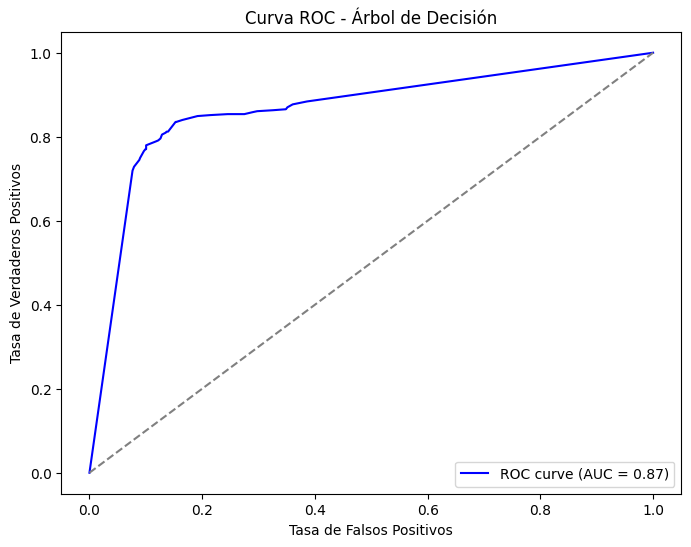

In [68]:
# Obtener las probabilidades de la clase positiva
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend(loc='lower right')
plt.show()


In [69]:
# Elegir un índice aleatorio del conjunto de prueba
random_index = random.randint(0, len(X_test) - 1)

# Obtener los datos de esa pelea
pelea_ejemplo = X_test.iloc[random_index:random_index+1]  # Mantener formato DataFrame
pelea_real = y_test.iloc[random_index]  # Etiqueta real

# Hacer la predicción
prediccion = best_model.predict(pelea_ejemplo)[0]  # El modelo devuelve 1 (True) o 0 (False)

# Determinar los ganadores
ganador_real = "Peleador B" if pelea_real else "Peleador A"
ganador_predicho = "Peleador B" if prediccion else "Peleador A"

# Mostrar resultados
print("===== PELEA ALEATORIA =====")
print(pelea_ejemplo)  # Muestra las estadísticas de la pelea
print("\nGanador Real: ", ganador_real)
print("Predicción del Modelo: ", ganador_predicho)


===== PELEA ALEATORIA =====
     TIME  KD_A  KD_B  SIG_STR_A  SIG_STR_B  TD_PORC_A  TD_PORC_B  SUB_ATT_A  \
225   300     0     0       0.47       0.36       0.57       0.25          0   

     SUB_ATT_B  REV_A  ...  Victorias_Sub_A  Victorias_Sub_B  \
225          1      0  ...                1                0   

     Victorias_Decision_A  Victorias_Decision_B  Derrotas_KO_A  Derrotas_KO_B  \
225                     3                     1              0              0   

     Derrotas_Sub_A  Derrotas_Sub_B  Derrotas_Decision_A  Derrotas_Decision_B  
225               0               0                    0                    1  

[1 rows x 75 columns]

Ganador Real:  Peleador A
Predicción del Modelo:  Peleador A
